# Titanic Data Science

In [1]:
import os

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import randint

## 1. Question and problem definition, beckground research

- The Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. Translated 32% survival rate.
- One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew.
- Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

## 2. Acquire / Seperate train and test datasets

In [2]:
dir = os.getcwd()
path_tr = os.path.join(dir, 'titanic/train.csv')
path_te = os.path.join(dir, 'titanic/test.csv')

train_df = pd.read_csv(path_tr)
test_df = pd.read_csv(path_te)

In [3]:
# train_df.head()
# test_df.head()
# train_df.info()
# test_df.info()

# train_df.describe()
# train_df.describe(include=['O'])

## 3. Wrangle, prepare, cleanse the data.

### Question 1: Does the dataset contain missing values?

Yes. Both in training and test set, there are a large number of missing entries in features "Age" and "Cabin".

In [4]:
# train_df.info()

In [5]:
# test_df.info()

### Question 2: Does the survival rate satisfy the beckground research?

No. But the training data just slightly suffers from data imbalance.

In [6]:
train_df['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

### Question 3: Is the likelihood of survival dependent on gender?

Yes. The majority of survivors were women.

In [7]:
def bar_chart_survival(data, features, title=None, stacked=True):
    survived = data[data['Survived'] == 1][features].value_counts()
    dead = data[data['Survived'] == 0][features].value_counts()
    df = pd.DataFrame({'Survived': survived, 'Dead': dead}).transpose()
    ax = df.plot(kind='bar', stacked=stacked, figsize=(5, 5), title=title)

    print(data.groupby(features)['Survived'].mean())

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


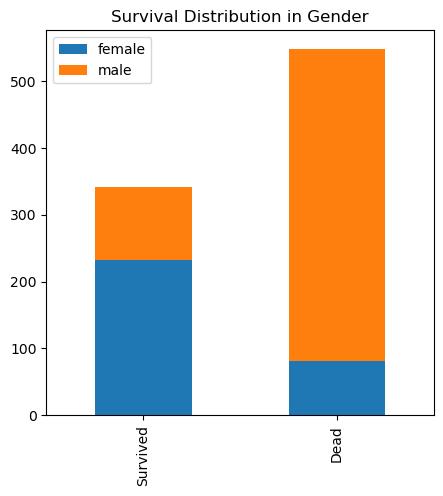

In [8]:
bar_chart_survival(train_df, 'Sex', 'Survival Distribution in Gender')

### Question 4: Is the likelihood of survival dependent on class?

Yes.

- The passenger from class 1 has high survival rate.
- Almost 50% of the class 2 passenger survived.
- Most passenger was in class 3 but has small survival rate.

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


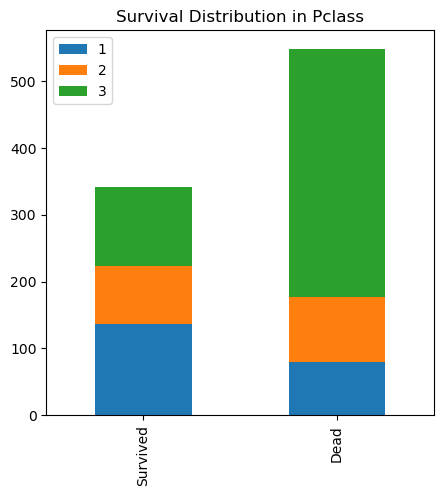

In [9]:
bar_chart_survival(train_df, 'Pclass', 'Survival Distribution in Pclass')

### Question 5: Does distribution of gender result in high survival rate in class 1?

Not exactly. Female has always high survival rate in all classes, but male also has slightly higher survival rate in 1st class,

Pclass  Sex   
1       female    0.968085
        male      0.368852
2       female    0.921053
        male      0.157407
3       female    0.500000
        male      0.135447
Name: Survived, dtype: float64


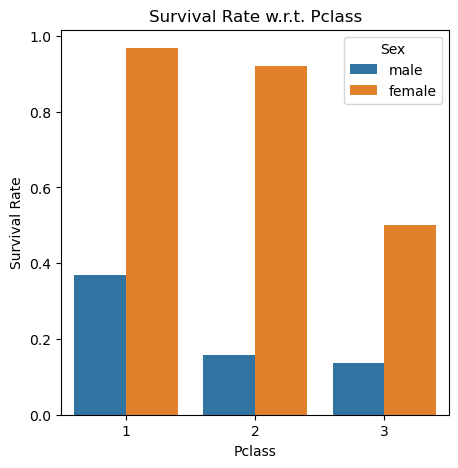

In [10]:
plt.figure(figsize=(5, 5))
plt.title('Survival Rate w.r.t. Pclass')
bar = sns.barplot(x='Pclass', y='Survived', hue='Sex', errorbar=None, data=train_df)
bar.set_ylabel('Survival Rate')

print(train_df.groupby(['Pclass', 'Sex'])['Survived'].mean())

### Question 6: Is the likelihood of survival dependent on age?

No. From age distribution we don't get additional information. The swarm plots just show that the survival rate depends on gender and class again.

In [11]:
def plot_distribution(data, feature, title=[None, None]):
    _, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(15, 5))
    sns.kdeplot(data[feature], ax=ax_1)
    ax_1.set_title(title[0])
    sns.kdeplot(data[data['Survived'] == 1][feature], ax=ax_2)
    sns.kdeplot(data[data['Survived'] == 0][feature], ax=ax_2)
    ax_2.set_title(title[1])
    ax_2.legend(['Survived', 'Not Survived'])

def plot_swarm_survival(data, feature_1, feature_2, title=None):
    _, ax = plt.subplots(figsize=(15, 5))
    ax.grid(True)
    ax.set_title(title)
    sns.swarmplot(y=feature_1, x=feature_2, hue='Survived', data=data)

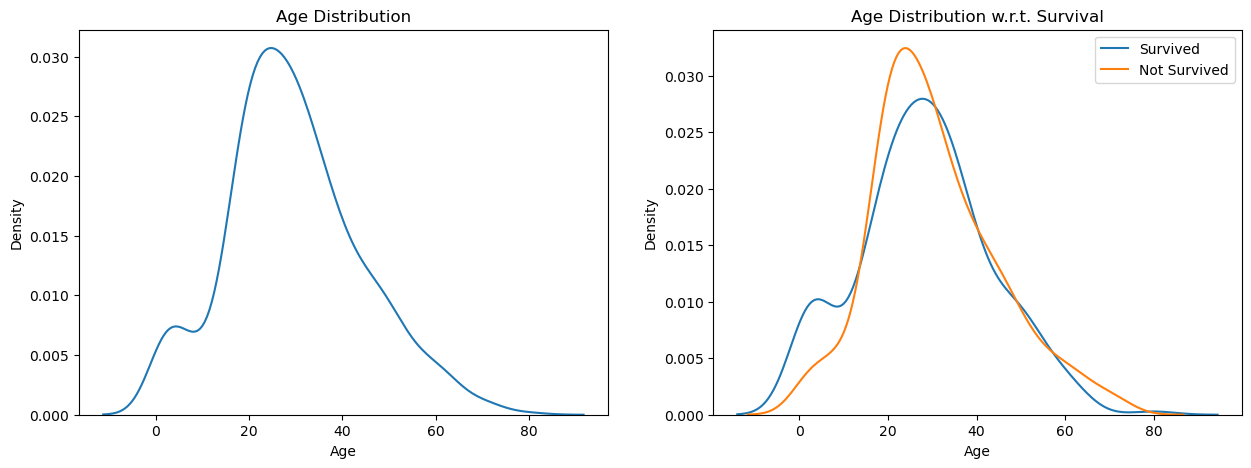

In [12]:
plot_distribution(train_df, 'Age', ['Age Distribution', 'Age Distribution w.r.t. Survival'])

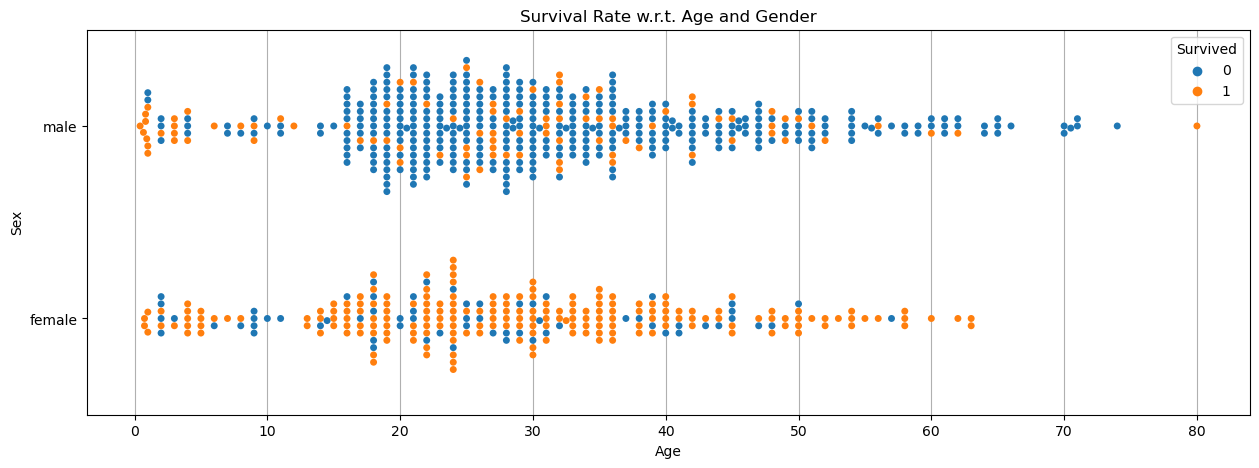

In [13]:
plot_swarm_survival(train_df, 'Sex', 'Age', 'Survival Rate w.r.t. Age and Gender')

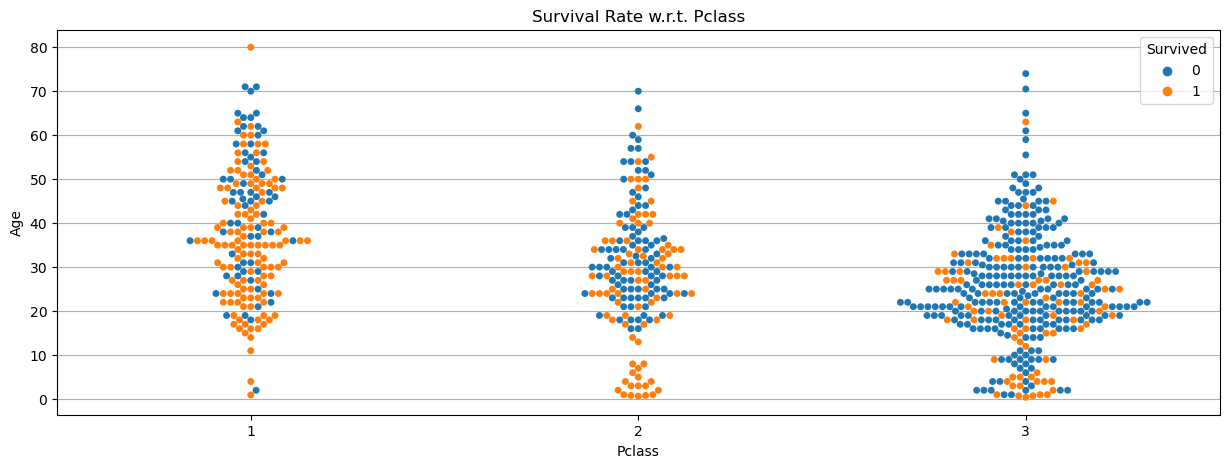

In [14]:
plot_swarm_survival(train_df, 'Age', 'Pclass', 'Survival Rate w.r.t. Pclass')

### Question 7: Is the likelihood of survival dependent on ticket price?

Yes. We converte fare to categories to get more useful information. The survival rate decreases as fare decreases.

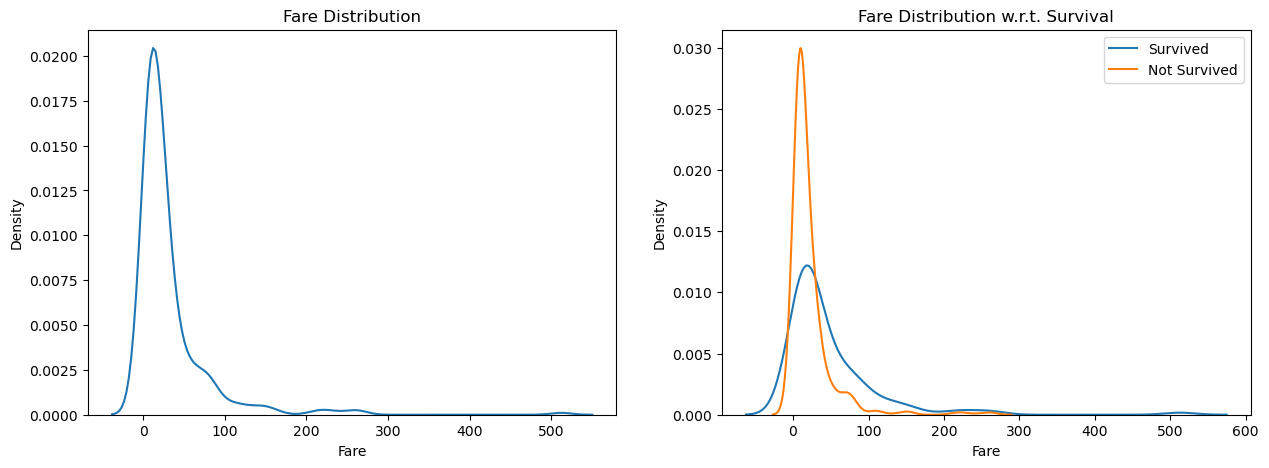

In [15]:
plot_distribution(train_df, 'Fare', ['Fare Distribution', 'Fare Distribution w.r.t. Survival'])

In [16]:
def plot_quartiles(data, feature, categories ,title=None):
    plt.figure(figsize=(5, 5))
    plt.title(title)
    fare_ranges = pd.qcut(data[feature], len(categories), labels=categories)
    print(fare_ranges)
    bar = sns.barplot(x=fare_ranges, y=data['Survived'], errorbar=None)
    bar.set_ylabel('Survival Rate')

0          Cheap
1         Luxury
2       Standard
3         Luxury
4       Standard
         ...    
886     Standard
887    Expensive
888    Expensive
889    Expensive
890        Cheap
Name: Fare, Length: 891, dtype: category
Categories (4, object): ['Cheap' < 'Standard' < 'Expensive' < 'Luxury']


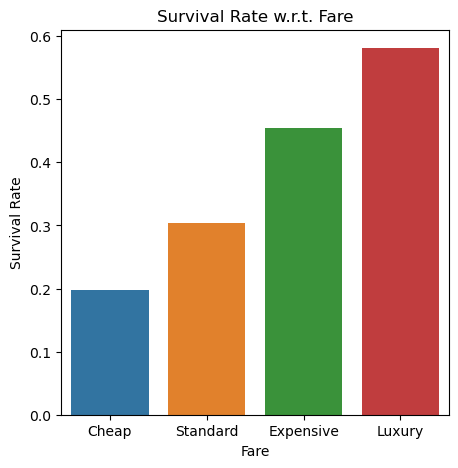

In [17]:
cat = ['Cheap', 'Standard', 'Expensive', 'Luxury']
plot_quartiles(train_df, 'Fare', cat, 'Survival Rate w.r.t. Fare')

### Question 8: Is the likelihood of survival dependent on the place of embarkation?

Not directly. We can see the majority of passengers embarked from Southampton, the passengers embarked from Southampton have lower survival rate.

In [18]:
train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [19]:
def countplot_compare(data, feature_1, feature_2, title=None):
    plt.figure(figsize=(5, 5))
    plt.title(title)
    cp = sns.countplot(x=feature_1, hue=feature_2, data=data)

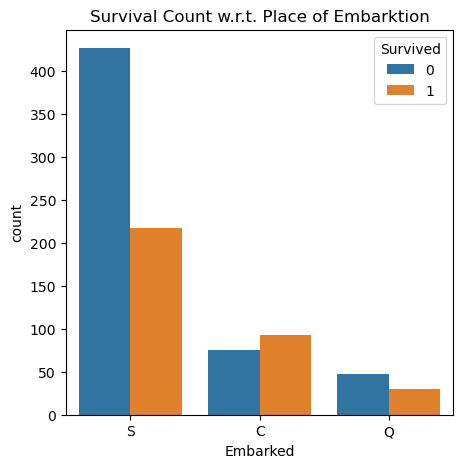

In [20]:
countplot_compare(train_df, 'Embarked', 'Survived', 'Survival Count w.r.t. Place of Embarktion')

### Question 9: Why is the likelihood of survival dependent on the place of embarkation?

We show the distribution of Pclass and Gender w.r.t. the place of embarktion, such that the place of embarktion can indirectly influence the chance of survival.

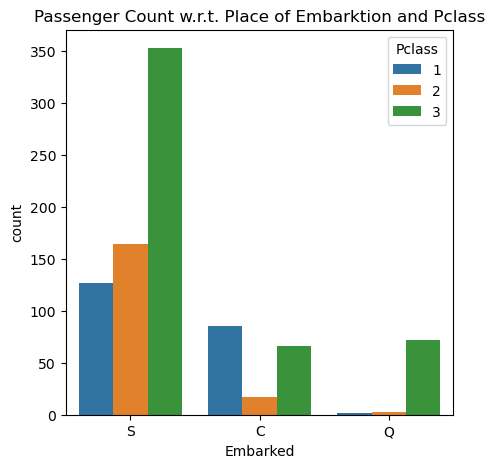

In [21]:
countplot_compare(train_df, 'Embarked', 'Pclass', 'Passenger Count w.r.t. Place of Embarktion and Pclass')

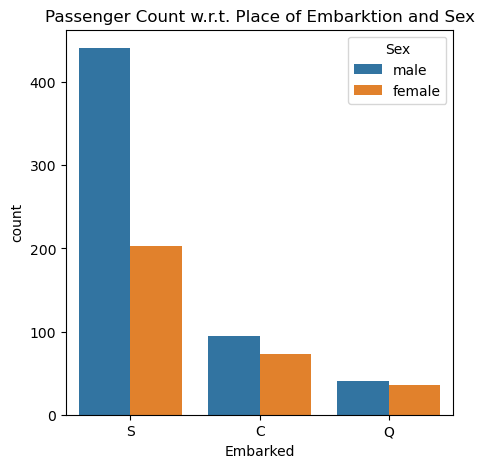

In [22]:
countplot_compare(train_df, 'Embarked', 'Sex', 'Passenger Count w.r.t. Place of Embarktion and Sex')

### Question 10: Is the likelihood of survival dependent on the family size on board?

Yes. Passangers with small family size had more chance to suivive.

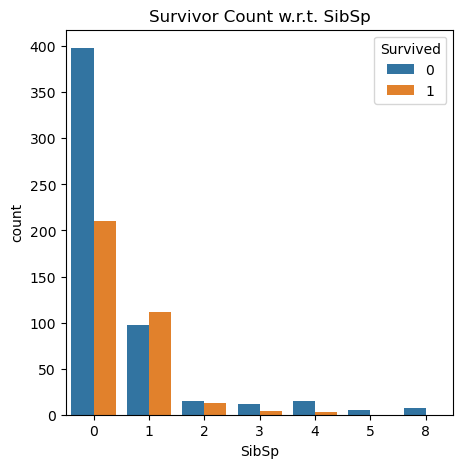

In [23]:
countplot_compare(train_df, 'SibSp', 'Survived', 'Survivor Count w.r.t. SibSp')

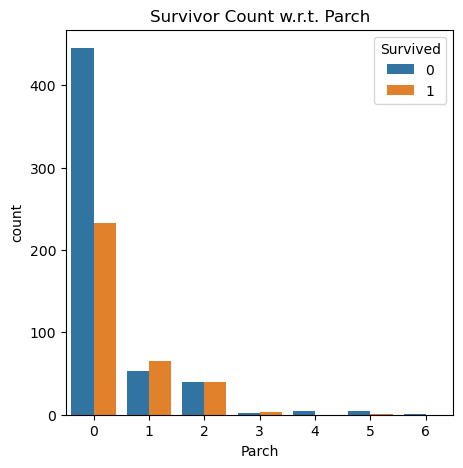

In [24]:
countplot_compare(train_df, 'Parch', 'Survived', 'Survivor Count w.r.t. Parch')

### Question 11: How to utilize family size to predict survival rate?

We extract the title from the name and converte it to small title categories. We can see female titles result in a higher survival rate, while the passenger with Master title has a high survival rate.

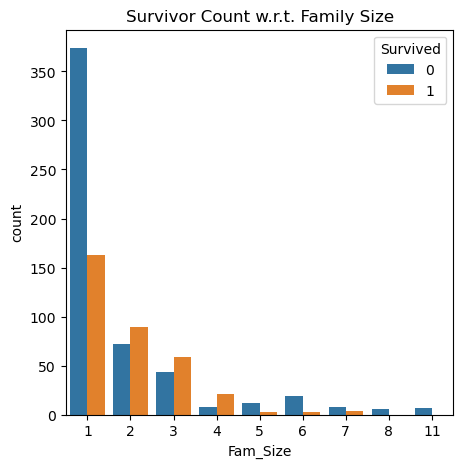

In [25]:
train_df_ = train_df.copy()
train_df_['Fam_Size'] = train_df['SibSp'] + train_df['Parch'] + 1

countplot_compare(train_df_, 'Fam_Size', 'Survived', 'Survivor Count w.r.t. Family Size')

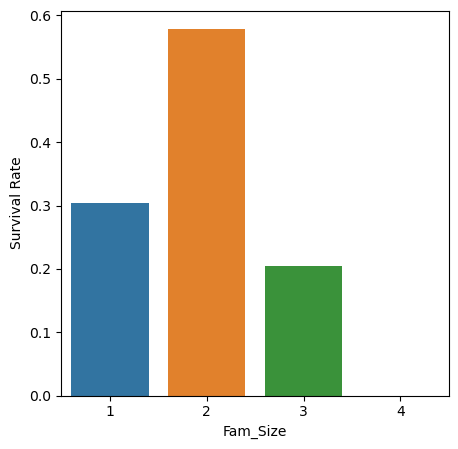

In [26]:
train_df_['Fam_Size'] = pd.cut(train_df_['Fam_Size'], [0, 1, 4, 7, 11], labels=['1', '2', '3', '4'])

plt.figure(figsize=(5, 5))
bar = sns.barplot(x='Fam_Size', y='Survived', errorbar=None, data=train_df_).set_ylabel('Survival Rate')

### Question 12: How does name influence the chance to survive?

We extract the title from the name and converte it to small title categories. We can see female titles result in a higher survival rate, while the passenger with Master title has a high survival rate.

In [27]:
train_df_ = train_df.copy()
train_df_['Title'] = train_df_['Name'].str.extract('([A-Za-z]+)\.', expand=False)
train_df_['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

In [28]:
train_df_['Title'] = train_df_['Title'].replace(['Capt', 'Col', 'Don', 'Major', 'Rev', 'Sir', 'Jonkheer'], 'Mr')
train_df_['Title'] = train_df_['Title'].replace(['Mlle', 'Ms'], 'Miss')
train_df_['Title'] = train_df_['Title'].replace(['Dr'], 'Master')
train_df_['Title'] = train_df_['Title'].replace(['Mme', 'Lady', 'Countess', 'Dona'], 'Mrs')
train_df_['Title'].value_counts()

Mr        531
Miss      185
Mrs       128
Master     47
Name: Title, dtype: int64

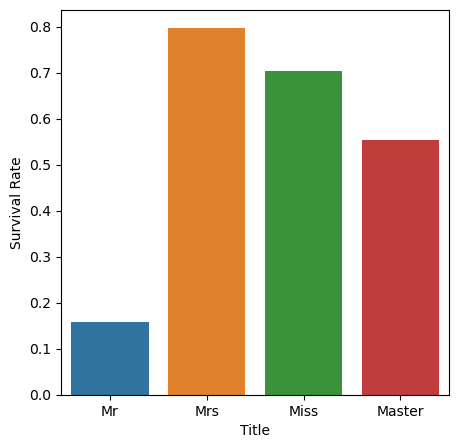

In [29]:
plt.figure(figsize=(5, 5))
bar = sns.barplot(x='Title', y='Survived', errorbar=None, data=train_df_).set_ylabel('Survival Rate')

### Question 13: How to utilize Cabin and Ticket to predict survival rate?

We extract prefix of ticket number and cumpute the length of ticket number.

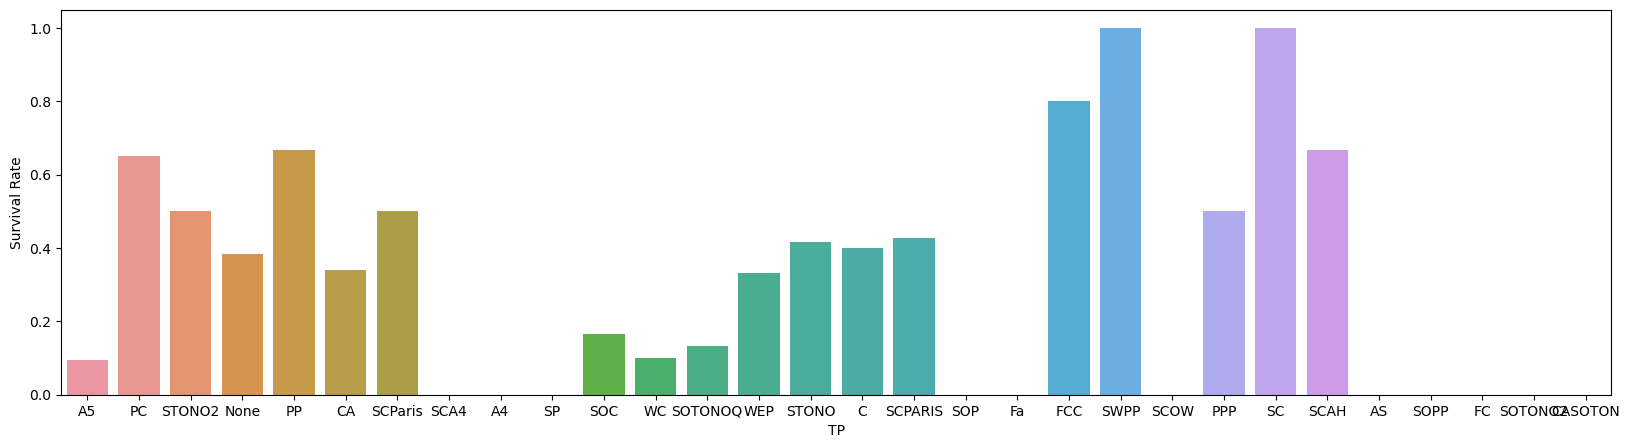

In [30]:
train_df_ = train_df.copy()
train_df_['TP'] = train_df_['Ticket'].apply(lambda x: x.split(' ', 1)[0] if len(x.split(' ', 1)) > 1 else 'None')
train_df_['TP'] = train_df_['TP'].apply(lambda x: x.replace('.', ''))
train_df_['TP'] = train_df_['TP'].apply(lambda x: x.replace('/', ''))
train_df_['TP'].value_counts()

plt.figure(figsize=(20, 5))
bar = sns.barplot(x='TP', y='Survived', errorbar=None, data=train_df_).set_ylabel('Survival Rate')

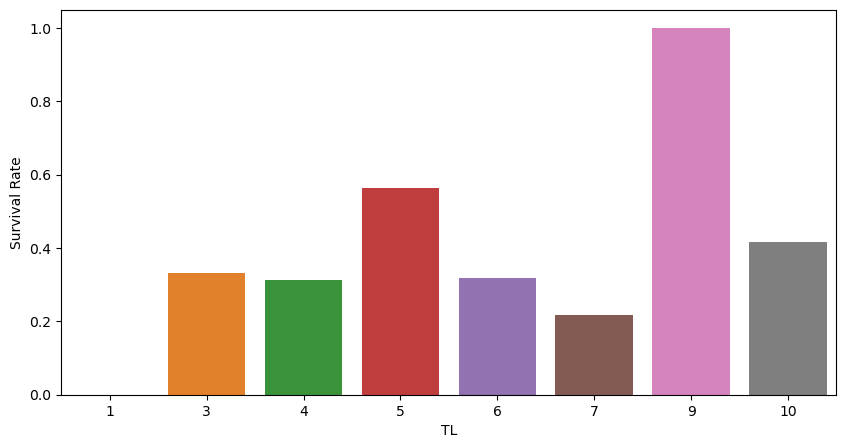

In [31]:
train_df_ = train_df.copy()
train_df_['TL'] = train_df_['Ticket'].apply(lambda x: len(x.split(' ', 1)[-1]))
train_df_['TL'].value_counts()

plt.figure(figsize=(10, 5))
bar = sns.barplot(x='TL', y='Survived', errorbar=None, data=train_df_).set_ylabel('Survival Rate')

## 4. Modeling, training and evaluating

In [32]:
class NewFeatureTitle(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Extract title from name.
        X['Title'] = X['Name'].str.extract('([A-Za-z]+)\.', expand=False)
        
        # Categorize.
        X['Title'] = X['Title'].replace(
            ['Capt', 'Col', 'Don', 'Major', 'Rev', 'Sir', 'Jonkheer'], 'Mr')
        X['Title'] = X['Title'].replace(['Mlle', 'Ms'], 'Miss')
        X['Title'] = X['Title'].replace(['Dr'], 'Master')
        X['Title'] = X['Title'].replace(['Mme', 'Lady', 'Countess', 'Dona'],
                                        'Mrs')
        
        return X

In [33]:
class NewFeatureFamType(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Compute family size.
        X['Fam_Size'] = X['SibSp'] + X['Parch'] + 1
        # Categorize.
        X['Fam_Type'] = pd.cut(X['Fam_Size'], [0, 1, 4, 7, 11], 
                               labels=['Alone', 'Small', 'Big', 'Very Big'])
        
        return X

In [34]:
class NewFeatureTicketPrefix(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['TP'] = X['Ticket'].apply(lambda x: x.split(' ', 1)[0] if len(x.split(' ', 1)) > 1 else 'None')
        X['TP'] = X['TP'].apply(lambda x: x.replace('.', ''))
        X['TP'] = X['TP'].apply(lambda x: x.replace('/', ''))
        return X

In [35]:
class NewFeatureTicketLen(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['TL'] = X['Ticket'].apply(lambda x: len(x.split(' ', 1)[-1]))
        return X

In [36]:
class NewFeatureFreeTicket(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['Free'] = X['Fare'] < 1
        return X

In [37]:
class NewFeatureFareDis(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.cat = ['Cheap', 'Standard', 'Expensive', 'Luxury']
        
    def fit(self, X, y=None):
        ser, bins = pd.qcut(X['Fare'], len(self.cat), retbins=True, labels=self.cat)
        self.ser = ser
        self.bins = bins
        return self
    
    def transform(self, X):
        X['Fare_Dis'] = pd.cut(X['Fare'], bins=self.bins, labels=self.cat, include_lowest=True)
        return X

In [38]:
class ResetDtype(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.num_cols = ['Fare']
        self.cat_cols = ['Pclass', 'Name', 'SibSp', 'Parch', 'Ticket', 'Embarked']
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = pd.DataFrame(X, columns=self.num_cols+self.cat_cols)
        X[self.num_cols] = X[self.num_cols].astype('float64')
        X[self.cat_cols] = X[self.cat_cols].astype('object')
        return X

In [39]:
class Drop(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.cols = ['Pclass', 'Embarked', 'Title', 'Fam_Type', 'TP', 'TL', 'Free', 'Fare_Dis']
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X[self.cols]
        return X

In [40]:
# 1st pipeline
num_cols = ['Fare']
cat_cols = ['Pclass', 'Name', 'SibSp', 'Parch', 'Ticket', 'Embarked']

num_tf = Pipeline([('imputer', SimpleImputer(strategy='median'))])
cat_tf = Pipeline([('imputer', SimpleImputer(strategy='most_frequent'))])

pipeline_1 = ColumnTransformer([('num', num_tf, num_cols),
                                ('cat', cat_tf, cat_cols)])

# 2nd pipeline
pipeline_2 = Pipeline([('title', NewFeatureTitle()),
                       ('family type', NewFeatureFamType()),
                       ('ticket prefix', NewFeatureTicketPrefix()),
                       ('ticket lenghth', NewFeatureTicketLen()),
                       ('free ticket', NewFeatureFreeTicket()),
                       ('fare distribution', NewFeatureFareDis())])

# 3rd pipeline
pipeline_3 = Pipeline([('pipeline 1', pipeline_1),
                       ('reset dtype', ResetDtype()),
                       ('pipeline 2', pipeline_2),
                       ('drop', Drop()),
                       ('onehot', OneHotEncoder(handle_unknown='ignore'))])

train_df_ = pipeline_3.fit_transform(train_df)
test_df_ = pipeline_3.transform(test_df)

In [41]:
param_distribs = {'n_estimators': randint(low=400, high=600),
                  'max_depth': randint(low=4, high=6)}

model = RandomForestClassifier(random_state=0)
rnd_search = RandomizedSearchCV(model, param_distributions=param_distribs,
                                n_iter=20, cv=8, scoring='neg_mean_squared_error', random_state=0)
rnd_search.fit(train_df_, train_df['Survived'])

cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.44310052939550765 {'max_depth': 4, 'n_estimators': 447}
0.4289650567919489 {'max_depth': 5, 'n_estimators': 592}
0.4289650567919489 {'max_depth': 5, 'n_estimators': 595}
0.423741417531717 {'max_depth': 5, 'n_estimators': 409}
0.423741417531717 {'max_depth': 5, 'n_estimators': 421}
0.4418279676802421 {'max_depth': 4, 'n_estimators': 436}
0.4224105382275196 {'max_depth': 5, 'n_estimators': 470}
0.43927178463019995 {'max_depth': 4, 'n_estimators': 488}
0.44310052939550765 {'max_depth': 4, 'n_estimators': 458}
0.4224105382275196 {'max_depth': 5, 'n_estimators': 439}
0.4289650567919489 {'max_depth': 5, 'n_estimators': 574}
0.43927178463019995 {'max_depth': 4, 'n_estimators': 481}
0.4276621897244933 {'max_depth': 5, 'n_estimators': 425}
0.4224105382275196 {'max_depth': 5, 'n_estimators': 472}
0.4289650567919489 {'max_depth': 5, 'n_estimators': 548}
0.4289650567919489 {'max_depth': 5, 'n_estimators': 597}
0.4418279676802421 {'max_depth': 4, 'n_estimators': 479}
0.4289650567919489 {'max_dept

## 5. Predicting

In [42]:
pipeline_final = Pipeline([('pipeline 1', pipeline_1),
                           ('reset dtype', ResetDtype()),
                           ('pipeline 2', pipeline_2),
                           ('drop', Drop()),
                           ('onehot', OneHotEncoder(handle_unknown='ignore')),
                           ('model', RandomForestClassifier(random_state=0, n_estimators=500, max_depth=5))])

pipeline_final.fit(train_df, train_df['Survived'])
y_pred = pipeline_final.predict(test_df)

In [43]:
output = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Survived': y_pred})
output.to_csv('submission.csv', index=False)